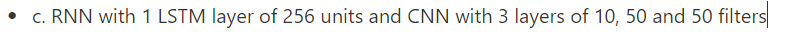

# MIST_CNN_Decoder

## Load Data

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

### clone git

In [ ]:
%cd /content/gdrive/MyDrive/project_3/MIST

/content/gdrive/MyDrive/project 3/MIST


In [ ]:
! git clone https://github.com/kryashashwi/MIST_CNN_Decoder.git

Cloning into 'MIST_CNN_Decoder'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Unpacking objects: 100% (26/26), done.


### get data from MIST_CNN_Decoder

into /content/gdrive/MyDrive/project 3/PE/data

In [32]:
import numpy as np
import copy

## Network

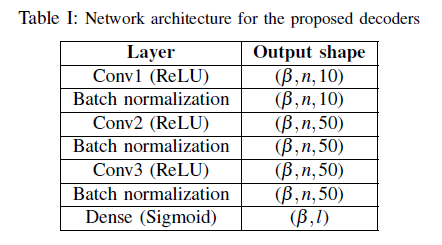

In [33]:
import tensorflow as tf
import numpy as np
from keras.layers.core import Dense
from keras.layers import Conv1D,Flatten, BatchNormalization, Input
from keras import backend as K
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [34]:
def MIST_model(input_shape , output_shape):  
  input_batch=Input(shape=input_shape)
  conv1 = Conv1D(10, 24, activation='relu',padding='same')(input_batch)
  batch_norm1=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv1)
  conv2 = Conv1D(50, 24, activation='relu',padding='same')(batch_norm1)
  batch_norm2=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv2)
  conv3 = Conv1D(50, 24, activation='relu',padding='same')(batch_norm2)
  batch_norm3=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv3)
  flatten = Flatten()(batch_norm3)
  msg_out = Dense(output_shape, activation='sigmoid')(flatten)

  return Model(inputs=input_batch,outputs=msg_out)

 

In [35]:
k = 500     #dataword length                 
rate = 1/2  #encoder rate is used 
N = int(k/rate)  #codeword length, 

In [36]:
model = MIST_model((N,1),k)
optimizer = 'adam'           
loss = 'mse'                
model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000, 1)]         0         
                                                                 
 conv1d_9 (Conv1D)           (None, 1000, 10)          250       
                                                                 
 batch_normalization_9 (Batc  (None, 1000, 10)         40        
 hNormalization)                                                 
                                                                 
 conv1d_10 (Conv1D)          (None, 1000, 50)          12050     
                                                                 
 batch_normalization_10 (Bat  (None, 1000, 50)         200       
 chNormalization)                                                
                                                                 
 conv1d_11 (Conv1D)          (None, 1000, 50)          6005

In [37]:
#model.load_weights("/content/gdrive/MyDrive/project_3/MIST/500_conv.hdf5")

In [38]:
#Calculate PSF from Eb/N0
def get_sigma(train_SNR_Eb):
    train_SNR_Es = train_SNR_Eb + 10*np.log10(1.0*k/N)
    train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))
    return(train_sigma)

#Setting SNR range
SNR_dB_start_Eb = -1
SNR_dB_stop_Eb = 7
SNR_points = 9
SNR_dB_start_Es = SNR_dB_start_Eb + (10*np.log10(1.0*k/N))
SNR_dB_stop_Es = SNR_dB_stop_Eb + (10*np.log10(1.0*k/N))

SNR_range=np.linspace(SNR_dB_start_Es, SNR_dB_stop_Es, SNR_points)
sigmas=np.sqrt(1/(2*10**(SNR_range/10)))



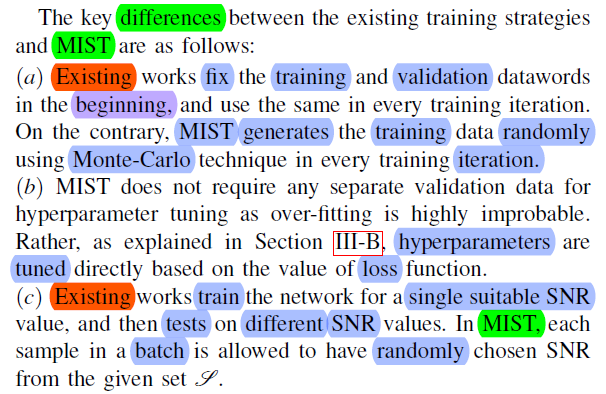!


In [39]:
def convenc(data,g1,g2):
    enc_msg = np.zeros([2*k])
    enc_msg[0::2] = (np.convolve(data,g1)%2)[0:k]
    enc_msg[1::2] = (np.convolve(data,g2)%2)[0:k]
    return enc_msg   

In [40]:
def ber(y_true, y_pred):
    return  K.mean(K.cast(K.not_equal(y_true, K.round(y_pred)),dtype='float32'))

In [43]:
batch_size=1024
train_batch=1024
test_batch=1024
#Number of samples to test on for each SNR. Currently set as 10 for demo purpose.    
n_samples= 8

for i in range(0,len(sigmas)):
    for ii in range(0,n_samples):
        #Generating dataword and codeword
        #(5,7), memory 2 convolutional encoder used
        g1=[1,1,1] #7
        g2=[1,0,1] #5

        uncoded = np.random.randint(0,2,size=(train_batch,k))
        encoded = np.zeros([uncoded.shape[0], 2 * uncoded.shape[1]])

        for iii in range(0,train_batch):
        #     uncoded[zz,:] = np.random.randint(0,2,size=(k)) 
            encoded[iii,:] = convenc (uncoded[iii,:],g1,g2)

        #Modulate
        signal = 2*encoded - 1

       	#Adding noise
        # for kk in range(0,len(s_test)):
        #     y_test[kk] = s_test[kk] + np.random.normal(0, sigmas[i], np.shape(s_test[kk]))

        noisy_signal = signal + np.random.normal(0, sigmas[i], size= np.shape(signal))

        ## train 
        print("epoch  {}/{}".format(ii,n_samples))
        x_train = np.expand_dims(noisy_signal,axis=2)
        model.fit(x_train,uncoded, epochs = 1, batch_size = train_batch , verbose=2)


epoch  0
1/1 - 18s - loss: 0.3244 - ber: 0.4972 - 18s/epoch - 18s/step
epoch  1
1/1 - 18s - loss: 0.3268 - ber: 0.4960 - 18s/epoch - 18s/step
epoch  2
1/1 - 19s - loss: 0.3283 - ber: 0.4946 - 19s/epoch - 19s/step
epoch  3
1/1 - 24s - loss: 0.3284 - ber: 0.4929 - 24s/epoch - 24s/step
epoch  4
1/1 - 18s - loss: 0.3285 - ber: 0.4936 - 18s/epoch - 18s/step
epoch  5
1/1 - 18s - loss: 0.3264 - ber: 0.4906 - 18s/epoch - 18s/step
epoch  6
1/1 - 18s - loss: 0.3252 - ber: 0.4904 - 18s/epoch - 18s/step
epoch  7
1/1 - 18s - loss: 0.3236 - ber: 0.4882 - 18s/epoch - 18s/step
epoch  8
1/1 - 19s - loss: 0.3215 - ber: 0.4877 - 19s/epoch - 19s/step
epoch  9
1/1 - 18s - loss: 0.3202 - ber: 0.4864 - 18s/epoch - 18s/step
epoch  10
1/1 - 18s - loss: 0.3189 - ber: 0.4840 - 18s/epoch - 18s/step
epoch  11
1/1 - 18s - loss: 0.3176 - ber: 0.4821 - 18s/epoch - 18s/step
epoch  12
1/1 - 18s - loss: 0.3168 - ber: 0.4799 - 18s/epoch - 18s/step
epoch  13
1/1 - 18s - loss: 0.3164 - ber: 0.4787 - 18s/epoch - 18s/step
ep

KeyboardInterrupt: ignored

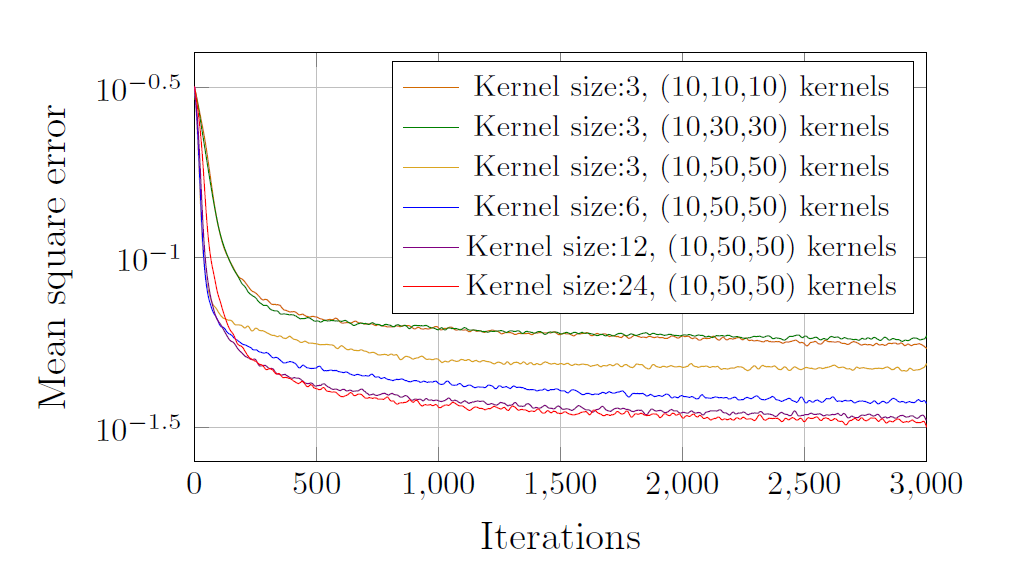

In [11]:
convenc2d(uncoded,g1,g2)

ValueError: ignored

In [ ]:
def conv(data,filter):
  output = np.zeros(data.shape)
  output[:,i]

In [12]:
enc_msg = np.zeros([uncoded.shape[0],2*uncoded.shape[1]])
enc_msg[:,0::2] = conv2d(uncoded,g1)%2)[:,0:k]
enc_msg[:,1::2] = conv2d(uncoded,g2)%2)[:,0:k]

ValueError: ignored

In [16]:
np.convolve([[1,2,3],[1,2,3]][:],[0,1,0.5],)

ValueError: ignored

In [ ]:
batch_size=1024
train_batch=1024
test_batch=1024
#Number of samples to test on for each SNR. Currently set as 10 for demo purpose. 
#Testing    
n_samples=10 

for i in range(0,len(sigmas)):
    for ii in range(0,n_samples):
        #Generating dataword and codeword
        #(5,7), memory 2 convolutional encoder used
        g1=[1,1,1] #7
        g2=[1,0,1] #5
        # for zz in range(0,train_batch):
        #     uncoded[zz,:] = np.random.randint(0,2,size=(k)) 
        #     encoded = convenc(uncoded[zz,:],g1,g2)
        #     x[zz,:] = copy.deepcopy(encoded)

        uncoded = np.random.randint(0,2,size=(train_batch,k))
        encoded = convenc2d(uncoded,g1,g2)

        #Modulate
        signal = 2*encoded - 1

       	#Adding noise
        # for kk in range(0,len(s_test)):
        #     y_test[kk] = s_test[kk] + np.random.normal(0, sigmas[i], np.shape(s_test[kk]))

        noisy_signal = signal + np.random.normal(0, sigmas[i], np.shape(signal))

        ## train 
        x_train = np.expand_dims(noisy_signal,axis=2)
        model.fit(x_train,uncoded, batch_size = train_batch , verbose=2)
        #Decoding noisy message
        y_test=np.expand_dims(y_test,axis=2)
        msg_rec = model.predict(y_test)
        #Calculating metrics
        err_block=0
        for qq in range(0,len(msg_rec)):
            if list(np.round(msg_rec[qq,:]))!=list(uncoded[qq,:]):
                err_block=err_block+1
        bler=err_block*1.0/len(msg_rec)
        print(round(SNR_range[i]),ii,bler, model.evaluate(y_test, uncoded, batch_size=test_batch, verbose=2)[1])